In [1]:
# Tests extract step itself, given known matrices

In [1]:
import numpy as np
import pickle
import matplotlib.pyplot as plt

from scipy.sparse import diags

In [2]:
# retrieve instrument response matrix

file_name = "../sample.pkl"
open_file = open(file_name, "rb")
loaded_data = pickle.load(open_file)
open_file.close()

In [3]:
# instrument response matrix A
A_mat = loaded_data

In [4]:
# make fake empirical detector readout and noise array

# 2D array of counts on detector
detector_measured = np.random.normal(loc=0,size=(200,100))

detector_variance = 0.1*np.random.normal(loc=0,size=(200,100))

In [5]:
# make weight matrix

w = 1./detector_variance.flatten()
W = diags(w, 0)

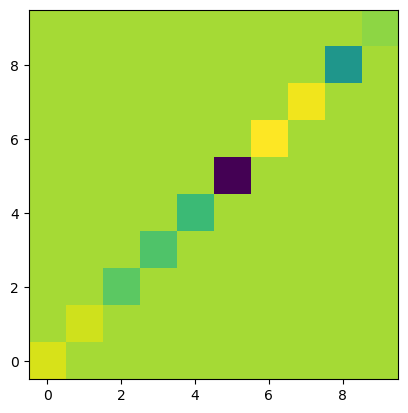

'\nplt.imshow(detector_measured, origin="lower")\nplt.show()\n\nplt.imshow(detector_variance, origin="lower")\nplt.show()\n'

In [15]:

plt.imshow(W.toarray()[0:10,0:10], origin="lower")
plt.show()

'''
plt.imshow(detector_measured, origin="lower")
plt.show()

plt.imshow(detector_variance, origin="lower")
plt.show()
'''

In [2]:
def extract(self, im, variance=None, thresh=3e-4):
        "invert linear response to recover cube"
        _log.debug('extract called')
        # compute weight array
        from scipy.sparse import diags
        if variance is None:
            w = n.ones(self.sim.ndetpix, dtype=n.float) # uniform weights
        else:
            w = 1./variance.flatten()
        if self.badpix is not None:
            wb = n.nonzero(self.badpix.flat)[0]
            w[wb] = 0.
        if n.any(n.isnan(im)):
            wb = n.nonzero(n.isnan(im.flat))[0]
            im[n.isnan(im)] = 0. # TEMP
            w[wb] = 0.
        W = diags(w, 0)

        # compute matrices/vectors
        ATW = self.A.T.dot(W) # A^T . W
        self.report(ATW, 'ATW')
        ATWA = ATW.dot(self.A) # A^T . W . A
        self.report(ATWA, 'ATWA')
        ATWx = ATW.dot(im.flat)

        # compute damping coefficient
        ATWAdiag = ATWA.diagonal()
        damp = thresh * ATWAdiag.max()

        # get least-squares solution
        from scipy.sparse.linalg import lsmr
        _log.info('running least-squares solver ...')
        # solve (ATWA)S = ATWx for S, where S is science signal and x is image
        spec_lw, istop, itn, normr, normar, norma, conda, normx = \
          lsmr(ATWA, ATWx,
               damp=damp,
               )
        _log.info('done.')

              
        # reformat structure into datacube
        spectra = n.empty((self.sim.nll, self.nlam), dtype=n.float)
        spectra[:] = n.nan
        spectra[self.wlw] = spec_lw
        return spectra